In [1]:
import numpy as np
import pandas as pd
from glob import glob 
from tqdm import tqdm
import seaborn as sns 

# for converting the text file containing the quarry locations into csv file
import csv

# for computing the geographical distance between two points 
import math


from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, auc, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from datetime import datetime
import h5py
from sklearn.preprocessing import LabelEncoder
from scipy import stats, signal
from sklearn.preprocessing import StandardScaler
import obspy
from obspy.geodetics.base import gps2dist_azimuth, gps2dist_azimuth
from obspy.clients.fdsn import Client
import time
pd.set_option('display.max_columns', None)
from joblib import dump, load
from obspy.signal.filter import envelope
import tsfel


import sys
sys.path.append('../feature_extraction_scripts/physical_feature_extraction_scripts')
import seis_feature
#from seis_feature import compute_physical_features
from tsfel import time_series_features_extractor, get_features_by_domain
from datetime import timedelta
import os
import sys
sys.path.append('../common_scripts')

from common_processing_functions import apply_cosine_taper
from common_processing_functions import butterworth_filter

import pickle
from zenodo_get import zenodo_get

## Defining some custom functions

In [2]:
# Function to extract information
def extract_datetime_info(date_str):
    date_obj = datetime.strptime(date_str, '%Y_%m_%d %H%M%S')
    hour_of_day = date_obj.hour - 8
    day_of_week = date_obj.weekday()  # Full day name
    month_of_year = date_obj.month  # Full month name
    return hour_of_day, day_of_week, month_of_year



def conv_to_datetime(df):
    new_df = []
    for i in range(len(df)):
        year = int(df[i].split('_')[0])
        month = int(df[i].split('_')[1])
        day = int(df[i].split('_')[2].split(' ')[0])
        hour = int(df[i].split('_')[2].split(' ')[1][0:2])
        minute = int(df[i].split('_')[2].split(' ')[1][2:4])
        second = int(df[i].split('_')[2].split(' ')[1][4:])
        new_df.append(obspy.UTCDateTime(year, month, day, hour, minute, second))
        
    return np.array(new_df)

In [3]:
pd.set_option('display.max_columns', None)
cat = pd.read_csv('../data/IRISExoticEventCatalog.txt', sep='|')


In [4]:
event_ids = cat['eventid'].values
source_types = cat['type'].values
source_subtypes = cat['subtype'].values

In [5]:
hod = [extract_datetime_info(i)[0] for i in cat['starttime'].values]
dow = [extract_datetime_info(i)[1] for i in cat['starttime'].values]
moy = [extract_datetime_info(i)[2] for i in cat['starttime'].values]

In [6]:
## computing the durations
sttime = cat['starttime']
ettime = cat['endtime']

starttimes = conv_to_datetime(sttime)
endtimes = conv_to_datetime(ettime)
dur = conv_to_datetime(ettime) - conv_to_datetime(sttime)

In [7]:
cat

,areaSource,areaSourceHigh,areaSourceLow,areaTotal,associationId,datlocation,depth,endtime,eventid,h,hHigh,hLow,hfall,hfall_high,hfall_low,l,lHigh,lLow,latitude,locuncertKm,longitude,lppotential,mass,massHigh,massLow,maxdistvhfKm,maxdistvhfReached,maxdisthfKm,maxdisthfReached,maxdistipKm,maxdistipReached,maxdistlpKm,maxdistlpReached,maxdistinfraKm,maxdistinfraReached,infraDetected,name,otherdataquality1to5,peakDischarge,peakDischargeLow,peakDischargeHigh,peakFlowheight,peakFlowheightLow,peakFlowheightHigh,starttime,sources,toeLat,toeLon,topLat,topLon,upstreamDrainarea,type,subtype,volume,volumeHigh,volumeLow
0,NaN,NaN,NaN,NaN,22,IRIS,NaN,2007_07_25 010251,22,1860.0,NaN,NaN,NaN,NaN,NaN,5760.0,NaN,NaN,61.10249,0.00,-140.30550,1,1.080000e+11,NaN,NaN,NaN,NaN,1079.0,True,NaN,NaN,1100.0,False,NaN,NaN,NaN,Mount Steele 2,5,NaN,NaN,NaN,NaN,NaN,NaN,2007_07_25 005835,"Allstadt, Kate E., McVey, Brennah G., and Malo...",61.14054,-140.25324,61.10249,-140.30550,NaN,rock and ice avalanche,Rock/ice/debris avalanches and slides,54000000.0,80500000.0,27500000.0
1,NaN,NaN,NaN,NaN,218,"RESIF, ETH, ORFEUS, LMU, BGR, IRIS, INGV",NaN,2017_08_23 093828,218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.29552,NaN,9.60190,0,NaN,NaN,NaN,NaN,NaN,246.0,False,NaN,NaN,0.0,NaN,NaN,NaN,NaN,"Piz Cengalo 4, Switzerland",1,NaN,NaN,NaN,NaN,NaN,NaN,2017_08_23 093617,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",NaN,NaN,NaN,NaN,NaN,landslide,Rock/ice/debris avalanches and slides,NaN,NaN,NaN
2,111000.0,NaN,NaN,1130000.0,127,IRIS,NaN,2017_07_22 205957,127,931.0,NaN,NaN,NaN,NaN,NaN,3730.0,NaN,NaN,60.07385,0.00,-139.84532,1,NaN,NaN,NaN,NaN,NaN,351.0,False,NaN,NaN,386.0,False,0.0,NaN,False,Lucia Glacier,4,NaN,NaN,NaN,NaN,NaN,NaN,2017_07_22 205630,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",60.06616,-139.90755,60.07385,-139.84532,NaN,rock avalanche,Rock/ice/debris avalanches and slides,3000000.0,4000000.0,2300000.0
3,100000.0,150000.0,65000.0,820000.0,186,"IRIS, NCEDC",NaN,2013_07_25 101727,186,690.0,760.0,640.0,NaN,NaN,NaN,2000.0,2100.0,1600.0,61.98450,0.00,-143.16830,1,4.000000e+10,NaN,NaN,NaN,NaN,500.0,False,NaN,NaN,500.0,False,NaN,NaN,NaN,Wrangell Mountains,4,NaN,NaN,NaN,NaN,NaN,NaN,2013_07_25 101456,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",61.97220,-143.14950,61.98450,-143.16830,NaN,rock and debris avalanche,Rock/ice/debris avalanches and slides,2600000.0,3900000.0,1800000.0
4,23400.0,NaN,NaN,NaN,147,IRIS,NaN,2019_05_13 144245,147,1240.0,NaN,NaN,NaN,NaN,NaN,4320.0,NaN,NaN,50.34480,0.00,-122.45110,1,NaN,NaN,NaN,NaN,NaN,391.0,True,NaN,NaN,301.0,True,NaN,NaN,NaN,Mount Joffre 1,5,NaN,NaN,NaN,NaN,NaN,NaN,2019_05_13 143955,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",50.36720,-122.41540,50.34480,-122.45110,NaN,"rock avalanche, debris flow",Rock/ice/debris avalanches and slides,1900000.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,NaN,NaN,NaN,NaN,185,Attachments below,NaN,2015_06_09 160558,185,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.67199,NaN,10.72268,0,NaN,NaN,NaN,3.0,NaN,3.0,True,NaN,NaN,0.0,NaN,NaN,NaN,NaN,Gadria 3,5,27.0,NaN,NaN,1.7,NaN,NaN,2015_06_09 151558,"Coviello, V., Arattano, M., Comiti, F., Maccon...",NaN,NaN,NaN,NaN,6.3,debris flow,Lahar/debris flow/outburst flood,12600.0,NaN,NaN
241,310000.0,520000.0,200000.0,7900000.0,19,IRIS,NaN,2012_06_11 222652,19,2400.0,2500.0,2300.0,NaN,NaN,NaN,9300.0,9500.0,9100.0,58.79367,0.00,-137.44247,1,2.000000e+10,NaN,NaN,NaN,NaN,890.0,True,NaN,NaN,1000.0,False,NaN,NaN,NaN,Mount Lituya main,4,NaN,NaN,NaN,NaN,NaN,NaN,2012_06_11 222400,"Allstadt, Kate E., McVey, Brennah G., and Malo...",58.81626,-137.30032,58.79367,-137.44247,NaN,rock and ice avalanche,Rock/ice/debris avalanches and slides,13000000.0,60000000.0,2800000.0
242,130000.0,160000.0,84000.0,3000000.0,188,"IRIS, NCEDC",NaN,2010_07_09 073820,188,1800.0,1900.0,

In [8]:
st_z = []
st_data = []
evids = []
hod_trace = []
dow_trace = []
moy_trace = []
event_types = []
event_subtypes = []
event_duration = []
trids = []


for i in range(len(event_ids)):
    try:
        files = glob("../data/iris_esec_waveforms/IRIS_ESEC/waveforms/"+str(event_ids[i])+'/*HZ*')
        for file in files:
            tr = obspy.read(file)
            
            d = tr[0].resample(100).data
            data = d[2000:17000]
            snr = np.nanmax(abs(data))/np.nanmean(abs(data))

            if snr > 2:
                st_data.append(data)
                evids.append(event_ids[i])           
                trids.append(tr[0].id)
                hod_trace.append(hod[i])
                dow_trace.append(dow[i])
                moy_trace.append(moy[i])
                event_types.append(source_types[i])
                event_subtypes.append(source_subtypes[i])
                event_duration.append(dur[i])
                
    except:
        pass
    

## Processing the downloaded waveforms for the events corresponding to ESEC

In [9]:
st_array = np.stack(st_data)
tapered_ex = apply_cosine_taper(st_array, taper_percent = 10) 
filtered_ex = np.array(butterworth_filter(tapered_ex, 1, 10, 100, 4, 'bandpass'))
ex_Z = filtered_ex
ex_Z = ex_Z/np.max(abs(ex_Z), axis = 1)[:, np.newaxis]



## Extracting Tsfel features

In [10]:
cfg_file = tsfel.get_features_by_domain()
# Extract features for surface event
features_ex_tsfel = pd.DataFrame([])

for i in tqdm(range(len(ex_Z))):
    try:
        df = time_series_features_extractor(cfg_file, ex_Z[i], fs=100,  verbose = 0)
        df['event_id'] = evids[i]
        df['trace_id'] = trids[i]
        features_ex_tsfel = pd.concat([features_ex_tsfel,df])
    except:
        pass

100%|██████████| 336/336 [11:15<00:00,  2.01s/it]


## Extracting physical features

In [11]:
code_sttime = time.time()
features_ex_physical = pd.DataFrame([])

for i in tqdm(range(len(ex_Z))):
    try: 
        df = seis_feature.FeatureCalculator(ex_Z[i]).compute_features()
        df['serial_no'] = i
        df['event_id'] = evids[i]
        df['trace_id'] = trids[i]
        df['hod'] = hod_trace[i]
        df['dow'] = dow_trace[i]
        df['moy'] = moy_trace[i]
        df['event_type'] = event_types[i]
        df['event_subtype'] = event_subtypes[i]
        df['duration'] = event_duration[i]
        features_ex_physical = pd.concat([features_ex_physical, df])
    except:
        pass
    
print(time.time() - code_sttime)

  0%|          | 0/336 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
100%|██████████| 336/336 [07:30<00:00,  1.34s/it]

450.6931993961334


## Loading the common dataset to extract only the features on which the model was trained

In [12]:
# loading the common dataset on which the model was trained so I can grab its columns. 
common_dataset = pd.read_csv('../results/common_dataset.csv')

/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (307,313,331,332,333,334,335) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [13]:
columns = common_dataset.columns[1:304]
columns = columns.append(pd.Index(['hod', 'dow', 'moy']))

In [14]:
# Later, you can load the model from disk
loaded_model = load('../results/best_rf_model_all_features_50_100.joblib')



In [16]:
# merging the event id and trace id to give each trace a unique id, that will allow us to merge physical and tsfel features
# for a given trace. 
features_ex_tsfel['source_id'] = features_ex_tsfel['trace_id']+'_'+features_ex_tsfel['event_id'].astype('str')
features_ex_physical['source_id'] = features_ex_physical['trace_id']+'_'+features_ex_physical['event_id'].astype('str')


# merging physical and tsfel features. 
features_all = pd.merge(features_ex_physical, features_ex_tsfel)


events_ids = features_all['event_id']

# grabbing the relevant columns
final_features = features_all.loc[:,columns]


scaler_params = pd.read_csv('../results/scaler_params.csv')
scaler_params.index = scaler_params['Feature']

final_scaler_params = scaler_params.loc[final_features.columns[:-3]]


for i in range(len(final_features.columns[:-3])):
    final_features.iloc[:,i] = (final_features.iloc[:,i]-final_scaler_params.iloc[i,2])/(final_scaler_params.iloc[i,3])
    
    
X_scaled = final_features

In [17]:
results = loaded_model.predict(X_scaled)
probs = loaded_model.predict_proba(X_scaled)

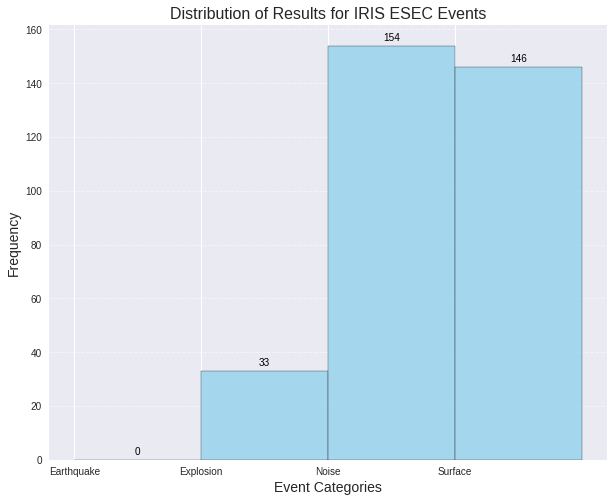

In [20]:
plt.style.use('seaborn')
plt.figure(figsize=(10, 8))
ax = sns.histplot(results, bins=range(5), color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Results for IRIS ESEC Events', fontsize=16)
plt.xlabel('Event Categories', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(range(4), labels=['Earthquake', 'Explosion', 'Noise', 'Surface'])
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Adding annotations with the number of events in each bin
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

## We want to plot how many avalanches were correctly classified or the distribution of labels of avalanches only. 

In [21]:
# merging the event id and trace id to give each trace a unique id, that will allow us to merge physical and tsfel features
# for a given trace. 
features_ex_tsfel['source_id'] = features_ex_tsfel['trace_id']+'_'+features_ex_tsfel['event_id'].astype('str')
features_ex_physical['source_id'] = features_ex_physical['trace_id']+'_'+features_ex_physical['event_id'].astype('str')

features_physical_flows = features_ex_physical[features_ex_physical['event_subtype'] == 'Lahar/debris flow/outburst flood']
features_physical_falls = features_ex_physical[features_ex_physical['event_subtype'] == 'Rock/debris falls']
features_physical_avalanches = features_ex_physical[features_ex_physical['event_subtype'] == 'Rock/ice/debris avalanches and slides']
features_physical_snow_av = features_ex_physical[features_ex_physical['event_subtype'] == 'Snow avalanches']


def compute_results_types(features_physical_flows):

    # merging physical and tsfel features. 
    features_all = pd.merge(features_physical_flows, features_ex_tsfel, on = 'source_id')


    events_ids = features_all['event_id_x']

    # grabbing the relevant columns
    final_features = features_all.loc[:,columns]

    scaler_params = pd.read_csv('../results/scaler_params.csv')
    scaler_params.index = scaler_params['Feature']

    final_scaler_params = scaler_params.loc[final_features.columns[:-3]]


    for i in range(len(final_features.columns[:-3])):
        final_features.iloc[:,i] = (final_features.iloc[:,i]-final_scaler_params.iloc[i,2])/(final_scaler_params.iloc[i,3])
    
    
    X_scaled = final_features
                                         
    results = loaded_model.predict(X_scaled)
    probs = loaded_model.predict_proba(X_scaled)
    durs = features_all['duration'].values
    esec_ids = [int(features_all['source_id'].values[i].split('_')[1]) for i in range(len(features_all))]     
    return results, durs, esec_ids
                                         

    
results_flows, dur_flows, esec_ids_flows = compute_results_types(features_physical_flows)
results_falls, dur_falls, esec_ids_falls = compute_results_types(features_physical_falls)
results_avalanches, dur_avalanches, esec_ids_avalanches = compute_results_types(features_physical_avalanches)
results_snow_av, dur_snow_av, esec_ids_snow_av = compute_results_types(features_physical_snow_av)

## Location wise distribution of results

In [22]:
snow_av_lats = [cat[cat['eventid'] == esec_ids_snow_av[i]]['latitude'].values[0] for i in range(len(esec_ids_snow_av))]
snow_av_lons = [cat[cat['eventid'] == esec_ids_snow_av[i]]['longitude'].values[0] for i in range(len(esec_ids_snow_av))]

fall_lats = [cat[cat['eventid'] == esec_ids_falls[i]]['latitude'].values[0] for i in range(len(esec_ids_falls))]
fall_lons = [cat[cat['eventid'] == esec_ids_falls[i]]['longitude'].values[0] for i in range(len(esec_ids_falls))]

av_lats = [cat[cat['eventid'] == esec_ids_avalanches[i]]['latitude'].values[0] for i in range(len(esec_ids_avalanches))]
av_lons = [cat[cat['eventid'] == esec_ids_avalanches[i]]['longitude'].values[0] for i in range(len(esec_ids_avalanches))]

flow_lats = [cat[cat['eventid'] == esec_ids_flows[i]]['latitude'].values[0] for i in range(len(esec_ids_flows))]
flow_lons =  [cat[cat['eventid'] == esec_ids_flows[i]]['longitude'].values[0] for i in range(len(esec_ids_flows))]









In [23]:
final_results = pd.DataFrame([])
final_results['labels'] = np.hstack([results_flows, results_falls, results_avalanches, results_snow_av])
final_results['source_subtype'] = ['flows']*len(results_flows) + ['falls']*len(results_falls) + ['avalanches']*len(results_avalanches) + ['snow avalanches']*len(results_snow_av)
final_results['duration'] = np.hstack([dur_flows, dur_falls, dur_avalanches, dur_snow_av])
final_results['ev_lats'] = np.hstack([flow_lats, fall_lats, av_lats, snow_av_lats])
final_results['ev_lons'] = np.hstack([flow_lons, fall_lons, av_lons, snow_av_lons])





In [25]:
temp_results = final_results[final_results['source_subtype'] == 'avalanches']

In [26]:
import pandas as pd
import plotly.express as px


df = temp_results.copy()
fig = px.scatter_geo(df, lat='ev_lats', lon='ev_lons', color='labels')
fig.show()


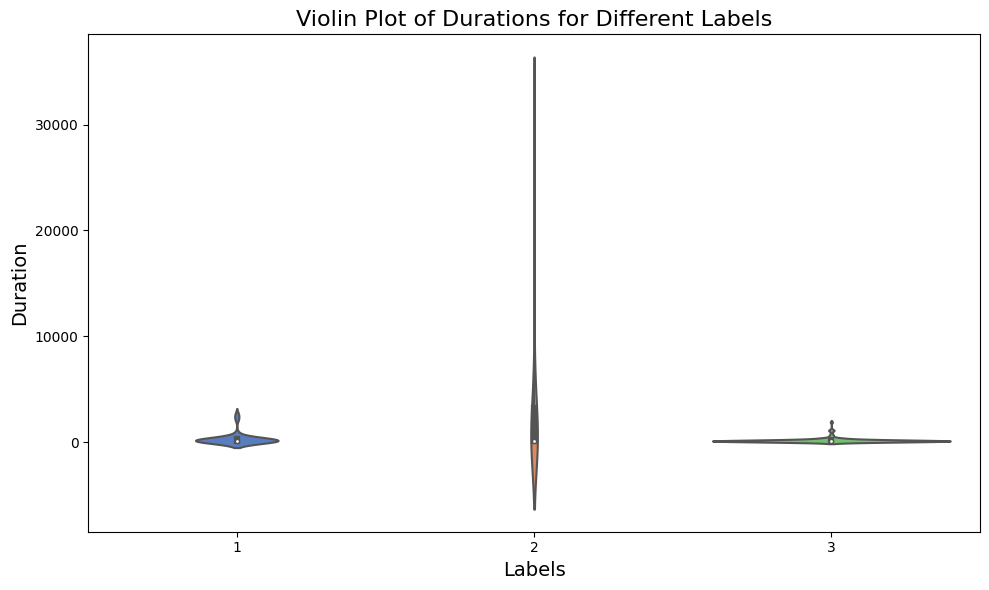

In [198]:
df = final_results.copy()

# Create the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='labels', y='duration', data=df, palette='muted')

# Add labels and title
plt.xlabel('Labels', fontsize=14)
plt.ylabel('Duration', fontsize=14)
plt.title('Violin Plot of Durations for Different Labels', fontsize=16)
#plt.ylim(-500, 700)
# Show the plot
plt.tight_layout()
plt.show()


<AxesSubplot:>

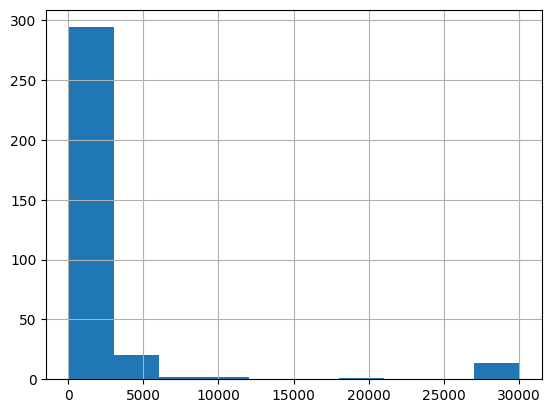

In [196]:
final_results['duration'].hist()


## Distribution of sources in different labels

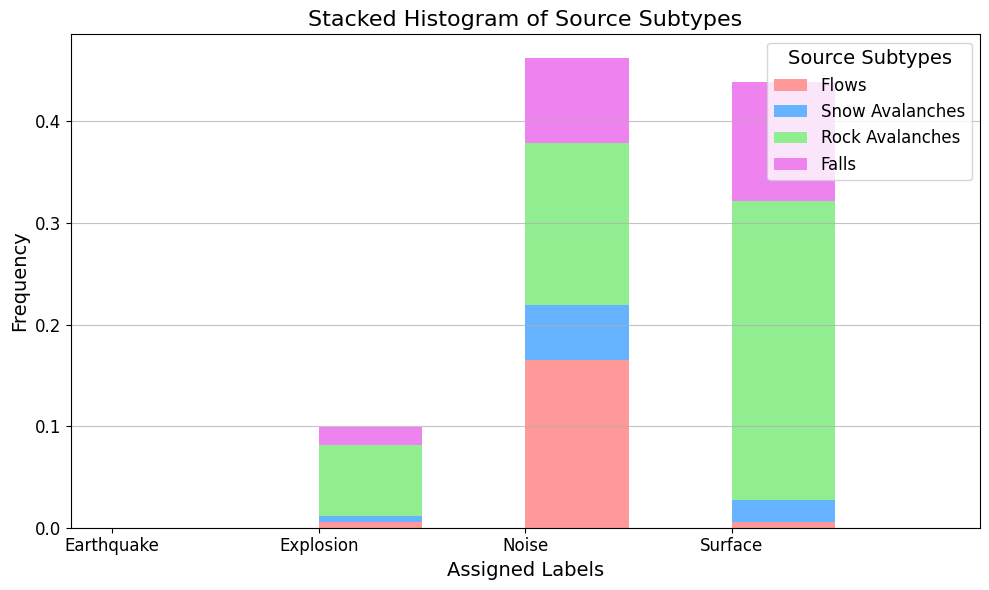

In [161]:
# Copy the DataFrame
df = final_results.copy()

# Count occurrences for each subtype per label
flows = df[df['source_subtype'] == 'flows']['labels']
snow_avalanches = df[df['source_subtype'] == 'snow avalanches']['labels']
rock_avalanches = df[df['source_subtype'] == 'avalanches']['labels']
falls = df[df['source_subtype'] == 'falls']['labels']

# Define the data
data = [flows, snow_avalanches, rock_avalanches, falls]

# Define the colors
colors = ['#ff9999', '#66b3ff', 'lightgreen', 'violet']

# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(data, bins=np.arange(0, 5, 1), stacked=True, density=True, color=colors, align='mid', label=['Flows', 'Snow Avalanches', 'Rock Avalanches', 'Falls'], width=0.5)

# Add labels, title, and legend
plt.xlabel('Assigned Labels', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Stacked Histogram of Source Subtypes', fontsize=16)
plt.xticks(np.arange(0, 4), ['Earthquake', 'Explosion', 'Noise', 'Surface'], fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Source Subtypes', fontsize=12, title_fontsize=14, loc='upper right')
plt.grid(axis='y', alpha=0.75)

# Show the plot
plt.tight_layout()
plt.show()


## Distribution of different labels in sources

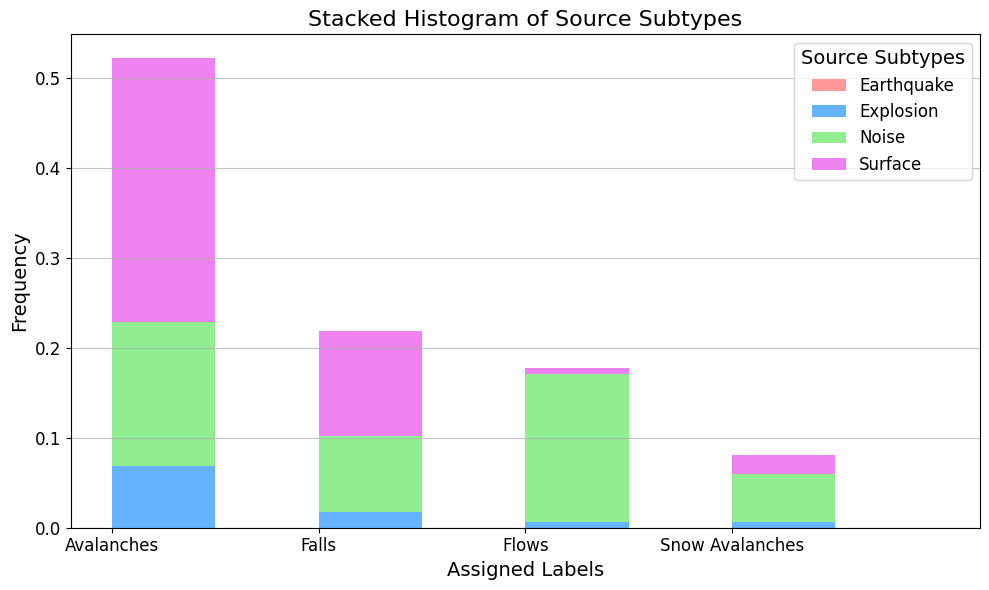

In [172]:
# Copy the DataFrame
df = final_results.copy()

# Convert source_subtype to categorical codes
df['source_subtype_code'] = df['source_subtype'].astype('category').cat.codes


# Count occurrences for each subtype per label
earthquakes = df[df['labels'] == 0]['source_subtype_code']
explosions = df[df['labels'] == 1]['source_subtype_code']
noise = df[df['labels'] == 2]['source_subtype_code']
surface = df[df['labels'] == 3]['source_subtype_code']

# Define the data
data = [earthquakes, explosions, noise, surface]

# Define the colors
colors = ['#ff9999', '#66b3ff', 'lightgreen', 'violet']

# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(data, bins=np.arange(0, 5, 1), stacked=True, density=True, color=colors, align='mid', label=['Earthquake', 'Explosion', 'Noise', 'Surface'], width=0.5)

# Add labels, title, and legend
plt.xlabel('Assigned Labels', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Stacked Histogram of Source Subtypes', fontsize=16)
plt.xticks(np.arange(0, 4), ['Avalanches', 'Falls', 'Flows', 'Snow Avalanches'], fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Source Subtypes', fontsize=12, title_fontsize=14, loc='upper right')
plt.grid(axis='y', alpha=0.75)

# Show the plot
plt.tight_layout()
plt.show()


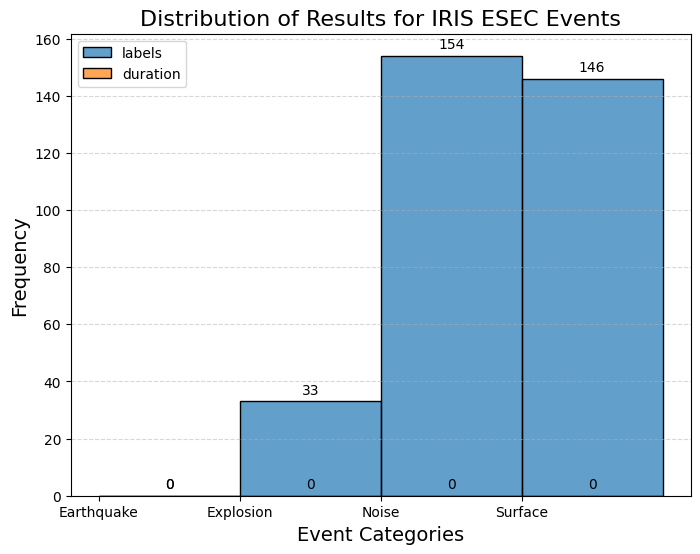

In [205]:
plt.figure(figsize=(8, 6))
ax = sns.histplot(final_results, bins=range(5), color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Results for IRIS ESEC Events', fontsize=16)
plt.xlabel('Event Categories', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(range(4), labels=['Earthquake', 'Explosion', 'Noise', 'Surface'])
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Adding annotations with the number of events in each bin
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()                                        

In [206]:
146/337


0.4332344213649852

([0, 1, 2, 3],
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

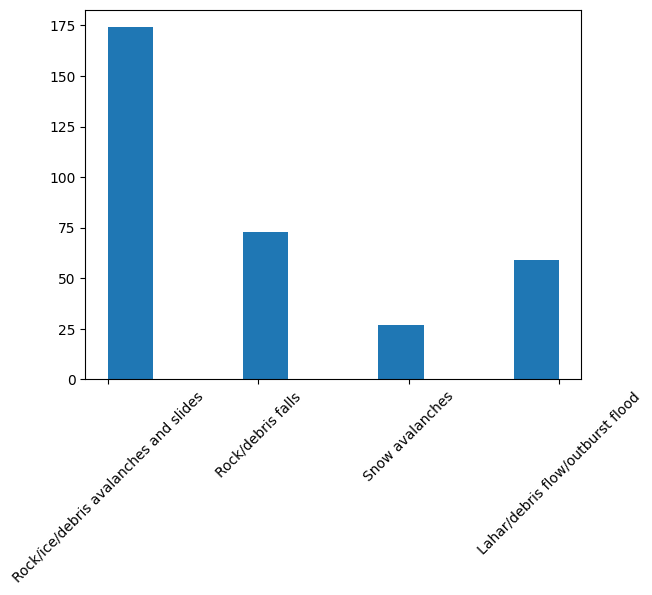

In [93]:
plt.hist(features_ex_physical['event_subtype'])
plt.xticks(rotation = 45)

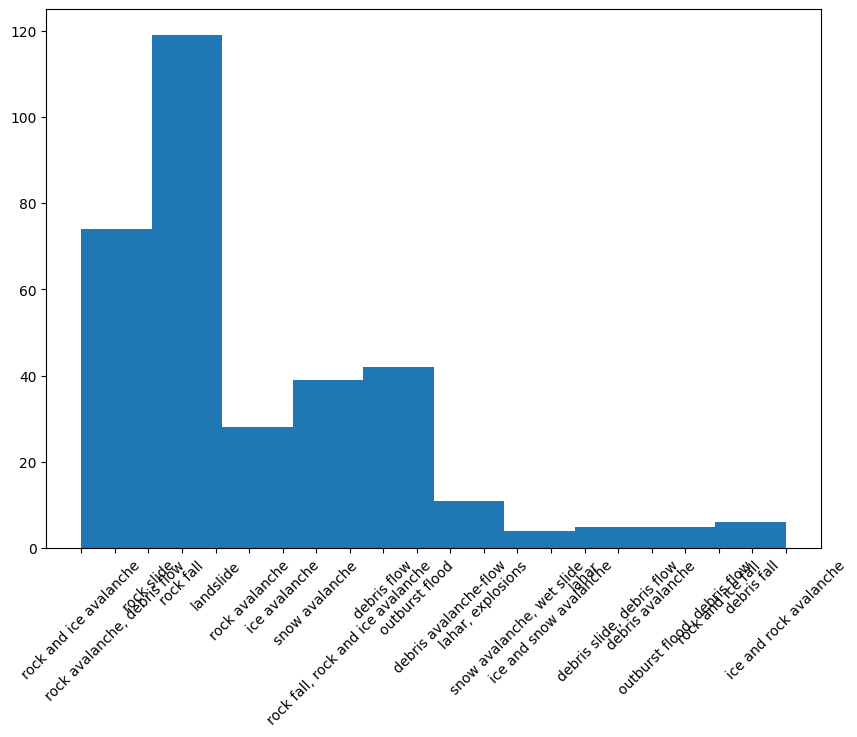

In [96]:
plt.figure(figsize = [10,7])
plt.hist(features_ex_physical['event_type'])
plt.xticks(rotation = 45)
plt.show()